# Load data

In [2]:
%matplotlib inline

In [3]:
import numpy as np 
import sklearn 
import scipy.misc
import matplotlib.pyplot as plt
import torch
from sklearn import metrics

In [4]:
# loading data
x_train = np.loadtxt("data/train_x.csv", delimiter=",")
y_train = np.loadtxt("data/train_y.csv", delimiter=",")
x_test = np.loadtxt("data/test_x.csv", delimiter=",")
print("Done")

Done


In [5]:
import sklearn
from sklearn import metrics

In [6]:
# encode y_train data in one-hot encoding
def to_one_hot(y):
    y_train_one_hot = [[0 for i in range(10)] for i in range(len(y))]
    for i in range(len(y)):
        y_train_one_hot[i][int(y[i])] = 1

    return np.array(y_train_one_hot)

def from_one_hot(one_hot_data):
    y = []
    for row in one_hot_data:
        y.append(np.argmax(row))

    return y

In [7]:
def show_img(img):
    plt.close()
    plt.imshow(img, cmap='gray_r')
    plt.show()

x_train_reshaped = x_train.reshape(-1, 64, 64)
y_train_reshaped = y_train.reshape(-1, 1) 
x_test_reshaped = x_test.reshape(-1, 64, 64)


In [8]:
def clean_data(x):
    """
    Because the only thing that matters is the numbers in the picture, which are black, 
    we recode the pixels as 1 if the pixel was 255 and 0 otherwise. To reduce noise and to
    reduce overflow/underflow in later stages.
    """
    new_data = []
    for row in x:
        new_row = []
        for pixel in row:
            if pixel == 255:
                new_row.append(1.0)
            else:
                new_row.append(-1.0)
        new_data.append(new_row)
    return np.array(new_data)



## Split training data into train / valid sets

In [9]:
from sklearn.model_selection import train_test_split
x_train_s, x_valid_s, y_train_s, y_valid_s = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2)
data = {
    "x_train": clean_data(x_train_s),
    "x_valid": clean_data(x_valid_s),
    "y_train": to_one_hot(y_train_s),
    "y_valid": to_one_hot(y_valid_s),
    "y_train_og": y_train_s,
    "y_valid_og": y_valid_s,
}

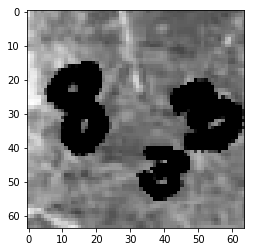

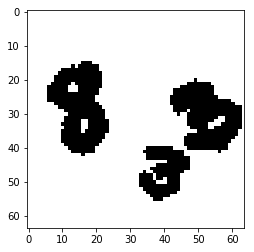

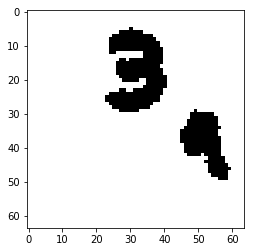

In [22]:
# x_cleaned_reshaped = data["x_train"].reshape(-1, 64, 64)

# x_train_s_reshaped = x_train_s.reshape(-1, 64, 64)
# show_img(x_train_s_reshaped[0])
# show_img(x_cleaned_reshaped[0])
# x_v_cleaned_reshaped = data["x_valid"].reshape(-1, 64, 64)
# show_img(x_v_cleaned_reshaped[0])

# Baseline Linear Classifier: Linear SVM

In [23]:

from sklearn.svm import LinearSVC

(40000, 4096)

In [25]:
def baseline_linear_svm(data):
    """
    Using out-of-the-box linear SVM to classify data
    """
    clf = LinearSVC()
    
    y_pred = clf.fit(data["x_train"], data["y_train"]).predict(data["x_valid"])
    print(y_pred)
    return metrics.accuracy_score(data["y_valid"], y_pred, average="macro"), y_pred
    
# score, y_pred = baseline_linear_svm(data)
# print(score)

# Neural Network

In [10]:
from scipy.special import expit
import torch

In [10]:
# def log_loss(output):
#     loss = []
#     for i in range(len(output)):
#         log_loss_sum = []
#         for j in range(10):
#             log_loss_sum.append(np.log(output[i][j]))
#         loss.append(log_loss_sum)
#     return np.array(loss)

In [20]:
class Layer:
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="sigmoid"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "sigmoid":
            self.activation_func = expit
            self.d_activation_func = lambda x: x * (1. - x)
            
        elif activation_func == "tanh":
            self.activation_func = lambda x: np.tanh(x)
            self.d_activation_func = lambda x: 1 - np.square(x)
            
        elif activation_func == "relu":
            self.activation_func = lambda x: np.maximum(0,x)
            self.d_activation_func = lambda x: x/x
        else:
            raise Error
        
    def feedforward(self, x):
        """
        return the predictions (represented by a probability)
        """
        # calculate stuff
        self.input = x
        before_activation = np.dot(x, self.w)
        self.output = self.activation_func(before_activation) 
        self.derivative = self.d_activation_func(before_activation)
        
        # if there's a next layer
        if self.next:
            passed_output = []
            # add bias to the end of each row of self.output
            try:
                passed_output = np.append(self.output, np.ones((self.output.shape[0], 1)), axis=-1)
            except ValueError:
                passed_output = np.append(self.output, 1) 
            
            # call next layer's feedforward step
            self.next.feedforward(passed_output)
 
    def backprop(self, prev_deltas):
        """
        compute derivatives and adjust w
        """ 
        deltas = prev_deltas * self.derivative
        if self.prev:
            self.prev.backprop(np.dot(self.w[:-1], deltas.T).T)
        self.w = self.w - (self.learning_rate * np.dot(self.input.T, deltas))

class OutputLayer(Layer):
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="softmax"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "softmax":
            self.activation_func = lambda x: 1 / (1 + np.exp(-x))
            self.backprop_func = lambda x, target: x - target
            
        elif activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.backprop_func = lambda x, target: self.d_sigmoid(x) * (x - target)
            
        else:
            pass
        
        # Value is unused.
        self.d_activation_func = lambda x: None
     
    def backprop(self, targets):
        deltas = self.backprop_func(self.output, targets)
        self.prev.backprop(np.dot(self.w[:-1], deltas.T).T)
        self.w = self.w - self.learning_rate * np.dot(self.input.T, deltas)
        
    
    def softmax(self, x):
        y = []
        for i in range(len(x)):
            row_exp = np.exp(x[i] - np.amax(x[i]))
            row_sum = np.sum(row_exp)
            y.append(row_exp/row_sum)
        return np.array(y)
        
    
class NeuralNet:
    def __init__(self, learning_rate, num_epochs):
        self.first = None
        self.last = None
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def add_layer(self, layer):
        """
        Add layer to the end
        """
        if not self.first:
            self.first = layer
            self.last = layer
            
        else:
            temp = self.last
            temp.next = layer
            layer.prev = temp
            self.last = layer
            
    def fit(self, x_train, y_train, x_valid, y_valid):
        print(x_valid.shape, y_valid.shape)
        x_input = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=-1)
        init_acc = self.get_accuracy(x_valid, y_valid)
        
        for i in range(self.num_epochs):

            for j in range(0, len(x_input), 1000):
                self.first.feedforward(x_input[j:j+1000])
                self.last.backprop(y_train[j:j+1000])
                
#             if (i+1)%25 == 0:
#                 print(i+1, "after feedforward & backprop")
#                 print(self.get_accuracy(x_valid))
                
        final_acc = self.get_accuracy(x_valid, y_valid)
        print("Initial accuracy, final accuracy", init_acc, final_acc)
        return final_acc
                
                
    def predict(self, x):
        x_input = np.append(x, np.ones((x.shape[0], 1)), axis=-1)
        self.first.feedforward(x_input)
        return self.last.output
    
    def get_accuracy(self, x_valid, y_valid):
        y_pred = self.predict(x_valid)
        return metrics.accuracy_score(from_one_hot(y_valid), from_one_hot(y_pred))

In [114]:
x_tr = data["x_train"]
y_tr = data["y_train"]


# neural_net = NeuralNet(1e-5, 2)
# # neural_net.k_fold(x_train, y_train)
# neural_net.add_layer(Layer(x_tr.shape[0], x_tr.shape[1] + 1, 1e-5, 3500, activation_func="relu"))
# # neural_net.add_layer(Layer(x_tr.shape[0], 300 + 1, 1e-6, 200))
# neural_net.add_layer(OutputLayer(x_tr.shape[0], 3500 + 1, 1e-5, 10))
# # neural_net.fit(x_tr, y_tr, data["x_valid"], data["y_valid"])
# # print("Done")
        
def k_fold(x, y):
    # divide into 5 folds
    y = to_one_hot(y)
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(x)
    accuracy_scores = []

    # for each fold, train and compute accuracy
    for train_index, test_index in kf.split(x):

        # create 'new' train & valid sets based on kfold split
        new_xt, new_yt = [], []
        new_xv, new_yv = [], []
        for ind in train_index:
            new_xt.append(x[ind])
            new_yt.append(y[ind])

        for ind in test_index:
            new_xv.append(x[ind])
            new_yv.append(y[ind])
        
        
        new_xt = np.array(new_xt)
        new_yt = np.array(new_yt)
        new_xv = np.array(new_xv)
        new_yv = np.array(new_yv)
        print(new_xt.shape, new_yt.shape, new_xv.shape, new_yv.shape)
        
        nn = NeuralNet(1e-5, 500)
        nn.add_layer(Layer(new_xt.shape[0], new_xt.shape[1] + 1, 1e-5, 3000, activation_func="relu"))
        nn.add_layer(OutputLayer(new_xt.shape[0], 3000 + 1, 1e-5, 10))
        acc_score = nn.fit(new_xt, new_yt, new_xv, new_yv)
        accuracy_scores.append(acc_score)

    print(accuracy_scores, np.average(accuracy_scores))
    return accuracy_scores

k_fold(x_train, y_train)

0.1317


Neural Net with Pytorch

In [10]:
class TorchLayer:
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="sigmoid"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = torch.from_numpy(np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))).cuda()
        self.learning_rate = learning_rate
        
        if activation_func == "sigmoid":
            self.activation_func = torch.sigmoid
            self.d_activation_func = self.d_sigmoid
            
            
        elif activation_func == "tanh":
            self.activation_func = self.tanh
            self.d_activation_func = self.d_tanh
            
        elif activation_func == "relu":
            self.activation_func = self.relu
            self.d_activation_func = self.d_relu
        else:
            raise Error
        
    def feedforward(self, x):
        """
        return the predictions (represented by a probability)
        """
        # calculate stuff
        self.input = x
        before_activation = torch.mm(x, self.w)
        self.output = self.activation_func(before_activation) 
        self.derivative = self.d_activation_func(before_activation)
        
        
        
        # if there's a next layer
        if self.next: 
            passed_output = torch.cat((self.output, torch.ones(self.output.size()[0], 1).double().cuda()), 1)
            # add bias to the end of each row of self.output
            # try:
            #     passed_output = np.append(self.output, np.ones((self.output.shape[0], 1)), axis=-1)
            # except ValueError:
            #     passed_output = np.append(self.output, 1) 
            
            # call next layer's feedforward step
            self.next.feedforward(passed_output)

        
    def backprop(self, prev_deltas):
        """
        compute derivatives and adjust w
        """ 
#         deltas = np.dot(self.derivative, prev_deltas )
        deltas = prev_deltas * self.derivative
        if self.prev:
            self.prev.backprop(torch.mm(self.w[:-1], deltas.t()).t())
        self.w = self.w - (self.learning_rate * torch.mm(self.input.t(), deltas))
    
    def tanh(self, x):
        return torch.tanh(x)
        
    def d_tanh(self, x):
        return 1 - (torch.tanh(x))**2
        
    def relu(self, x):
        return torch.clamp(x, min=0)
    
    def d_relu(self, x):
        return torch.gt(x, 0).double()
    
        
    def sigmoid(self, x):
        """
        sigmoid function
        """
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        """
        derivative of sigmoid
        """
        return x * (1. - x)
   
    
class TorchOutputLayer(TorchLayer):
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="softmax"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        self.w = torch.from_numpy(np.random.uniform(size=(self.input_cols,num_nodes)) / np.sqrt(self.input_cols)).cuda()
        self.learning_rate = learning_rate
        
        if activation_func == "softmax":
            self.activation_func = self.softmax
            self.backprop_func = lambda x, target: x - target
            
        elif activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.backprop_func = lambda x, target: self.d_sigmoid(x) * (x - target)
            
        else:
            pass
        
        # Value is unused.
        self.d_activation_func = lambda x: None
     
    def backprop(self, targets):
        deltas = self.backprop_func(self.output, targets)
        self.prev.backprop(torch.mm(self.w[:-1], deltas.t()).t())
        self.w = self.w - self.learning_rate * torch.mm(self.input.t(), deltas)
        
    
    def softmax(self, x):
#         e = np.exp(x - np.amax(x))
#         dist = e / np.sum(e)
#         return dist
#         e = np.exp(x-np.amax(x))
#         e_sum = np.sum(e, axis=1)
#         y = []
#         for i in range(len(x)):
#             row_exp = np.exp(x[i] - np.amax(x[i]))
#             row_sum = np.sum(row_exp)
#             y.append(row_exp/row_sum)
#         return np.array(y)
        return torch.nn.functional.softmax(torch.autograd.Variable(x), 1).data
        
    
class TorchNeuralNet:
    def __init__(self, learning_rate, num_epochs):
        self.first = None
        self.last = None
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def add_layer(self, layer):
        """
        Add layer to the end
        """
        if not self.first:
            self.first = layer
            self.last = layer
            
        else:
            temp = self.last
            temp.next = layer
            layer.prev = temp
            self.last = layer
            
    def fit(self, x_train, y_train):
        x_input = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=-1)
        # print("Initial accuracy")
        # print(self.get_accuracy())
        
        for i in range(self.num_epochs):

#             print(i, "before feedforward & backprop")
#             print(self.first.w)
#             print(self.first.next.w)
#             print(self.last.w)
            for j in range(0, len(x_input), 50):
                self.first.feedforward(torch.from_numpy(x_input[j:j+500]).cuda())
                self.last.backprop(torch.from_numpy(y_train[j:j+50]).double().cuda())
            
            #     
            # print(i, "after feedforward & backprop")
            # print(self.first.w)
            # print(self.first.next.w)
            # print(self.last.w)
            if (i+1)%25 == 0:
                print(i+1, "after feedforward & backprop")
                print(self.get_accuracy())
#                 print(self.get_train_accuracy())
                
        print(self.get_accuracy())
        print(self.get_train_accuracy())
                
    def predict(self, x):
        x_input = torch.from_numpy(np.append(x, np.ones((x.shape[0], 1)), axis=-1)).cuda()
        self.first.feedforward(x_input)
        return self.last.output.cpu().numpy()
    
    def get_accuracy(self):
        y_pred = np.empty((len(data["x_valid"]), 10), dtype=data["x_valid"].dtype)
        for i in range(0, len(data["x_valid"]), 1000):
            y_pred[i:i+1000] = self.predict(data["x_valid"][i:i+1000])
            
        return metrics.accuracy_score(data["y_valid_og"], from_one_hot(y_pred))
    
    def get_train_accuracy(self):
        y_pred = np.empty((len(data["x_train"]), 10), dtype=data["x_train"].dtype)
        for i in range(0, len(data["x_train"]), 1000):
            y_pred[i:i+1000] = self.predict(data["x_train"][i:i+1000])
            
        return metrics.accuracy_score(data["y_train_og"], from_one_hot(y_pred))


x_tr = data["x_train"]
y_tr = data["y_train"]

neural_net = TorchNeuralNet(1e-5, 400)

neural_net.add_layer(TorchLayer(x_tr.shape[0], x_tr.shape[1] + 1, 1e-4, 25, activation_func="tanh"))
neural_net.add_layer(TorchLayer(x_tr.shape[0], 25 + 1, 1e-4, 75, activation_func="relu"))
# neural_net.add_layer(TorchLayer(x_tr.shape[0], 4500 + 1, 1e-3, 3500, activation_func="tanh"))
neural_net.add_layer(TorchOutputLayer(x_tr.shape[0], 75 + 1, 1e-4, 10))

neural_net.fit(x_tr, y_tr)
# predict_y = neural_net.predict(data["x_valid"])
print("Done")
        
        

KeyboardInterrupt: 

In [13]:
neural_net.num_epochs = 300
neural_net.fit(x_tr, y_tr)

25 after feedforward & backprop
0.2732
50 after feedforward & backprop
0.2939
75 after feedforward & backprop
0.2941
100 after feedforward & backprop
0.3078
125 after feedforward & backprop
0.3084
150 after feedforward & backprop
0.2909
175 after feedforward & backprop
0.2872
200 after feedforward & backprop
0.3222
225 after feedforward & backprop
0.3145
250 after feedforward & backprop
0.3108
275 after feedforward & backprop
0.3208
300 after feedforward & backprop
0.3007
0.3007
0.8265


In [11]:
import gc
del neural_net
gc.collect()

0

Convolution Neural Network

In [11]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [12]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = []
        self.num_layers = 0
    
    def add_layer(self, layer):
        self.num_layers += 1
        self.add_module(str(self.num_layers), layer)
        self.layers.append(layer)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
class View_Layer(nn.Module):
    def __init__(self, param1, param2):
        super(View_Layer, self).__init__()
        self.param1 = param1
        self.param2 = param2
        
    def forward(self, x):
        return x.view(self.param1, self.param2)
    
    
def fit(cnn, x_train, y_train, epochs, lr=0.01, momentum=0.9):
    crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)
    
    
    for i in range(0, epochs):
        for j in range(0, x_train.shape[0], 500):
            x_in = Variable(torch.from_numpy(x_train[j:j+500]).cuda()).view(-1, 1, 64, 64)
            y_in = Variable(torch.from_numpy(y_train[j:j+500]).long().cuda())
        
            optimizer.zero_grad()
        
            y_pred = cnn(x_in)
            loss = crit(y_pred, y_in)
            loss.backward()
            optimizer.step()
            
#         if i%25 == 0:
#             print(i)
#             print(get_accuracy(cnn, data["x_valid"], data["y_valid"]))
            
def fit_loader(cnn, dataloader, epochs, lr=0.01, momentum=0.9):
    crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)
    
    for epoch in range(0, epochs):
        for i, entries in enumerate(dataloader, 0):
            x_in, y_in = entries
            x_in = Variable(x_in.cuda())
            y_in = Variable(y_in.long().cuda())
            
            optimizer.zero_grad()
        
            y_pred = cnn(x_in)
            loss = crit(y_pred, y_in)
            loss.backward()
            optimizer.step()
        
        

    
def predict(cnn, x):
    return cnn(Variable(torch.from_numpy(x).cuda().view(-1, 1, 64, 64))).cpu().data.numpy()

def predict_batch(cnn, x):
    y_pred = np.empty((len(x), 10), dtype=x.dtype)
    for i in range(0, len(x), 1000):
        y_pred[i:i+1000] = predict(cnn, x[i:i+1000])
            
    return y_pred

def get_accuracy(cnn, x_valid, y_valid):
    y_pred = np.empty((len(x_valid), 10), dtype=y_valid.dtype)
    for i in range(0, len(x_valid), 100):
        y_pred[i:i+100] = predict(cnn, x_valid[i:i+100])
            
    return metrics.accuracy_score(from_one_hot(y_valid), from_one_hot(y_pred))
    

# cnn = CNN()

# cnn.add_layer(nn.Conv2d(1, 12, 5))
# cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2,2))
# cnn.add_layer(nn.Conv2d(12, 24, 5))
# cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# cnn.add_layer(View_Layer(-1, 2704))
# cnn.add_layer(nn.Linear(2704, 120))
# cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.Linear(120, 84))
# cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.Linear(84, 10))

# cnn.double()
# cnn.cuda()

# x_tr = data["x_train"]
# y_tr = data["y_train_og"]

# fit(cnn, x_tr, y_tr, 60)
# print(get_accuracy(cnn, data["x_valid"], data["y_valid"]))

In [13]:
import time
import datetime
import logging

logger = logging.getLogger()

def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Jupyter console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('out.log')



In [14]:
import torchvision
import torchvision.transforms as transforms

In [15]:

from torch.utils.data import Dataset

class ImageArrayDataset(Dataset):
    
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self, idx):
        
        if self.transform:
            x_trans = self.transform(self.x[idx])
        
        return (x_trans, self.y[idx])
    

[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]]
Variable containing:
 3
[torch.cuda.LongTensor of size 1 (GPU 0)]



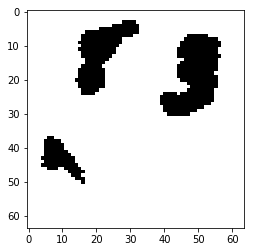

In [21]:

x_tr = data["x_train"].reshape(-1, 1, 64, 64)
y_tr = data["y_train_og"]



trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

# print(x_tr[0])

# print(trans(x_tr[0]))

# for i, j in zip(x_tr[0].reshape(-1), trans(x_tr[0]).numpy().reshape(-1)):
#     if (i != j):
#         print(str(i) + " != " + str(j))

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True, num_workers=2)

for i, entries in enumerate(loader, 0):
    x_in, y_in = entries
    x_in = Variable(x_in.cuda())
    y_in = Variable(y_in.long().cuda())
    
    print(x_in.data.cpu().numpy())
    print(y_in)
    
    show_img(np.array([255 if i == 1 else 0 for i in x_in.data.cpu().numpy()[0].reshape(-1)]).reshape(64, 64))
    break

In [25]:
log("Testing with 9 conv layers.")

x_tr = data["x_train"].reshape(-1, 1, 64, 64)
y_tr = data["y_train_og"]



trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 2
conv_4_pad = 1
conv_5_pad = 1
conv_6_pad = 0
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3
conv_11_kernel = 3
conv_12_kernel = 3

conv_1_drop = 0.05
conv_2_drop = 0.05
conv_3_drop = 0.05
conv_4_drop = 0.05
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1


conv_1_out = 25
conv_2_out = 35
conv_3_out = 50
conv_4_out = 65
conv_5_out = 80
conv_6_out = 90
conv_7_out = 100
conv_8_out = 110
conv_9_out = 120

drop_1_p = 0.5
drop_2_p = 0.5
drop_3_p = 0.5

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
# cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_9_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_9_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_9_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_9_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 25, lr=0.2)
cnn.train(False)
acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_1_kernel))
log("Accuracy: " + str(acc))
log("Train Accuracy: " + str(get_accuracy(cnn, data["x_train"], data["y_train"])))



2018-03-21 22:40:18.428041 Testing with 9 conv layers.
34
19
11
11
11
9
7
5
3
1080


Process Process-239:
Process Process-240:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-15-23860c439145>", line 17, in __getitem__
    x_trans = self.transform(self.x[idx])
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/tor

KeyboardInterrupt: 

  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py", line 232, in __call__
    return self.lambd(img)
  File "<ipython-input-25-baa14a40313a>", line 13, in <lambda>
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
  File "<ipython-input-25-baa14a40313a>", line 13, in <lambda>
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
KeyboardInterrupt


In [33]:
log("Testing with 9 conv layers.")

x_tr = data["x_train"].reshape(-1, 1, 64, 64)
y_tr = data["y_train_og"]



trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 1
conv_4_pad = 1
conv_5_pad = 0
conv_6_pad = 0
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0
conv_11_pad = 0
conv_12_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1
conv_11_stride = 1
conv_12_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3
conv_11_kernel = 3
conv_12_kernel = 3

drop_1_p = 0.5
drop_2_p = 0.5
drop_3_p = 0.5

conv_1_out = 20
conv_2_out = 30
conv_3_out = 45
conv_4_out = 60
conv_5_out = 70
conv_6_out = 80
conv_7_out = 90
conv_8_out = 95
conv_9_out = 105
conv_10_out = 110
conv_11_out = 115
conv_12_out = 120


cnn = CNN()


cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
# side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_10_out))
cnn.add_layer(nn.Conv2d(conv_10_out, conv_11_out, conv_11_kernel, padding=conv_11_pad, stride=conv_11_stride))
side_len = int((side_len - conv_11_kernel + (2 * conv_11_pad)) / conv_11_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_11_out))
cnn.add_layer(nn.Conv2d(conv_11_out, conv_12_out, conv_12_kernel, padding=conv_12_pad, stride=conv_12_stride))
side_len = int((side_len - conv_12_kernel + (2 * conv_12_pad)) / conv_12_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_12_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_12_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_12_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_12_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 35, lr=0.2)
cnn.train(False)
acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_11_out) + "\t" + str(conv_12_out) + "\t" + str(conv_1_kernel))
log("Accuracy: " + str(acc))
log("Train Accuracy: " + str(get_accuracy(cnn, data["x_train"], data["y_train"])))



2018-03-21 18:56:29.293940 Testing with 9 conv layers.
34
19
19
19
17
15
13
11
9
7
5
3
1080
Epoch: 0
0.1969
0.196975
Epoch: 1
0.2993
0.296175
Epoch: 2
0.3972
0.392175
Epoch: 3
0.5019
0.50355
Epoch: 4
0.6245
0.625625
Epoch: 5
0.7678
0.7712
Epoch: 6
0.8361
0.84485
Epoch: 7
0.874
0.87915
Epoch: 8
0.8959
0.901325
Epoch: 9
0.8958
0.902425
Epoch: 10
0.9182
0.924925
Epoch: 11
0.9213
0.9275
Epoch: 12
0.9278
0.93245
Epoch: 13
0.9342
0.938575
Epoch: 14
0.9221
0.931225
Epoch: 15
0.9323
0.941125
Epoch: 16
0.9329
0.9408
Epoch: 17
0.9369
0.94735
Epoch: 18
0.9399
0.94945
Epoch: 19
0.9459
0.9555
Epoch: 20
0.9413
0.952275
Epoch: 21
0.9447
0.95145
Epoch: 22
0.9448
0.95525
Epoch: 23
0.9488
0.957775
Epoch: 24
0.9454
0.956425
Epoch: 25
0.9455
0.957525
Epoch: 26
0.9515
0.961775


Process Process-444:
Process Process-443:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  

KeyboardInterrupt: 

In [37]:
log("Testing with 3 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

# for conv_2_kernel in [6, 5]:
for conv_1_out, conv_2_out, conv_3_out in [(10, 20, 30), (15, 25, 32)]:
#     for conv_2_out in range(20, 29, 4):
    for conv_1_kernel in range(3, 6):
        conv_2_kernel = conv_1_kernel
        conv_3_kernel = conv_1_kernel
#         for conv_2_kernel in range(6, 7):
        for conv_1_stride in range(1, 2):
            for conv_2_stride in range(1, 2):
                for conv_3_stride in range(1, 2):
                    for conv_1_pad in range(0, 1):
                        for conv_2_pad in range(0, 1):
                            for conv_3_pad in range(0, 1):
                                cnn = CNN()


                                cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
                                side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

                                cnn.add_layer(nn.ReLU())
                                cnn.add_layer(nn.MaxPool2d(2,2))
                                side_len = int(side_len / 2)

                                cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
                                side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

                                cnn.add_layer(nn.ReLU())
                                cnn.add_layer(nn.MaxPool2d(2, 2))
                                side_len = int(side_len / 2)

                                cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
                                side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

                                cnn.add_layer(nn.ReLU())
                                cnn.add_layer(nn.MaxPool2d(2, 2))
                                side_len = int(side_len / 2)

                                cnn.add_layer(View_Layer(-1, conv_3_out * side_len**2))
                                cnn.add_layer(nn.Linear(conv_3_out * side_len**2, 120))
                                cnn.add_layer(nn.ReLU())
                                cnn.add_layer(nn.Linear(120, 84))
                                cnn.add_layer(nn.ReLU())
                                cnn.add_layer(nn.Linear(84, 10))

                                cnn.double()
                                cnn.cuda()

                                fit(cnn, x_tr, y_tr, 20)
                                acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
                                log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_1_kernel))
                                log("Accuracy: " + str(acc))

                                if (acc > best_acc):
                                    best_acc = acc
                                    best_1_out = conv_1_out
                                    best_2_out = conv_2_out
                                    best_1_groups = conv_1_kernel
                                    best_2_groups = conv_2_kernel
                                    best_1_stride = conv_1_stride
                                    best_2_stride = conv_2_stride
                                    best_1_pad = conv_1_pad
                                    best_2_pad = conv_2_pad

                                    
log("Accuracy:" + str(best_acc))
log(str(best_1_out))
log(str(best_2_out))
log(str(best_1_kernel))
log(str(best_2_kernel))
log(str(best_1_stride))
log(str(best_2_stride))
log(str(best_1_pad))
log(str(best_2_pad))
                    

2018-03-19 19:26:18.988466 10	20	30	3
2018-03-19 19:26:18.989096 Accuracy: 0.6164
2018-03-19 19:29:37.583245 10	20	30	4
2018-03-19 19:29:37.584097 Accuracy: 0.771
2018-03-19 19:32:18.016987 10	20	30	5
2018-03-19 19:32:18.017770 Accuracy: 0.7795
2018-03-19 19:36:24.258667 15	25	32	3
2018-03-19 19:36:24.259274 Accuracy: 0.6234
2018-03-19 19:40:09.843407 15	25	32	4
2018-03-19 19:40:09.844238 Accuracy: 0.7893
2018-03-19 19:43:49.775582 15	25	32	5
2018-03-19 19:43:49.776196 Accuracy: 0.7839
2018-03-19 19:43:49.776518 Accuracy:0.7893
2018-03-19 19:43:49.776791 15
2018-03-19 19:43:49.777053 25
2018-03-19 19:43:49.777311 0
2018-03-19 19:43:49.777585 0
2018-03-19 19:43:49.777839 1
2018-03-19 19:43:49.778090 1
2018-03-19 19:43:49.778338 0
2018-03-19 19:43:49.778592 0


In [50]:
log("Testing with 4 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

# for conv_2_kernel in [6, 5]:
# for conv_1_out, conv_2_out, conv_3_out, conv_4_out in [(15, 30, 45, 60), (10, 20, 40, 80)]:
#     for conv_2_out in range(20, 29, 4):

#         for conv_2_kernel in range(6, 7):
    
for conv_1_pad in range(0, 3):
    conv_2_pad = conv_1_pad
    conv_3_pad = conv_2_pad
    conv_4_pad = conv_3_pad

    log("Padding is at " + str(conv_1_pad))
    
    for conv_1_stride in range(1, 4):
        conv_2_stride = conv_1_stride
        conv_3_stride = conv_2_stride
        conv_4_stride = conv_3_stride

        log("Sride is at " + str(conv_1_stride))
        
        for conv_1_kernel in range(5, 2, -1):
            conv_2_kernel = conv_1_kernel
            conv_3_kernel = conv_2_kernel
            conv_4_kernel = conv_3_kernel
            
            for conv_1_out, conv_2_out, conv_3_out, conv_4_out in [(15, 30, 45, 60), (10, 20, 40, 80), (20, 30, 40, 50), (20, 40, 80, 160)]:

                cnn = CNN()


                cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
                side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.MaxPool2d(2,2))
                side_len = int(side_len / 2)

#                 print(side_len)
                
                cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
                side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.MaxPool2d(2, 2))
                side_len = int(side_len / 2)

#                 print(side_len)
                
                cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
                side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)

#                 print(side_len)

                cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
                side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)
                
#                 print(side_len)
                
#                 print(str(conv_4_out * side_len**2))
                
                cnn.add_layer(View_Layer(-1, conv_4_out * side_len**2))
                cnn.add_layer(nn.Linear(conv_4_out * side_len**2, 120))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.Linear(120, 84))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.Linear(84, 10))

                cnn.double()
                cnn.cuda()

                fit(cnn, x_tr, y_tr, 25)
                acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
                log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_1_kernel))
                log("Accuracy: " + str(acc))

                if (acc > best_acc):
                    best_acc = acc
                    best_1_out = conv_1_out
                    best_2_out = conv_2_out
                    best_1_groups = conv_1_kernel
                    best_2_groups = conv_2_kernel
                    best_1_stride = conv_1_stride
                    best_2_stride = conv_2_stride
                    best_1_pad = conv_1_pad
                    best_2_pad = conv_2_pad

                                    
log("Accuracy:" + str(best_acc))
log(str(best_1_out))
log(str(best_2_out))
log(str(best_1_kernel))
log(str(best_2_kernel))
log(str(best_1_stride))
log(str(best_2_stride))
log(str(best_1_pad))
log(str(best_2_pad))
                    

2018-03-19 20:10:10.608837 Testing with 4 conv layers.
2018-03-19 20:10:10.610419 Padding is at 0
2018-03-19 20:10:10.610691 Sride is at 1
2018-03-19 20:16:01.468806 15	30	45	60	5
2018-03-19 20:16:01.469472 Accuracy: 0.8535
2018-03-19 20:20:44.995234 10	20	40	80	5
2018-03-19 20:20:44.996016 Accuracy: 0.8407
2018-03-19 20:27:31.291656 20	30	40	50	5
2018-03-19 20:27:31.292282 Accuracy: 0.8559
2018-03-19 20:39:30.290464 20	40	80	160	5
2018-03-19 20:39:30.291077 Accuracy: 0.8631
2018-03-19 20:45:13.819439 15	30	45	60	4
2018-03-19 20:45:13.820241 Accuracy: 0.8416
2018-03-19 20:50:18.450683 10	20	40	80	4
2018-03-19 20:50:18.451296 Accuracy: 0.8025
2018-03-19 20:56:11.003733 20	30	40	50	4
2018-03-19 20:56:11.004373 Accuracy: 0.8327
2018-03-19 21:06:09.380641 20	40	80	160	4
2018-03-19 21:06:09.381458 Accuracy: 0.8495
2018-03-19 21:12:02.861639 15	30	45	60	3
2018-03-19 21:12:02.862245 Accuracy: 0.7438


KeyboardInterrupt: 

In [57]:
log("Testing with 5 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

# for conv_2_kernel in [6, 5]:
# for conv_1_out, conv_2_out, conv_3_out, conv_4_out in [(15, 30, 45, 60), (10, 20, 40, 80)]:
#     for conv_2_out in range(20, 29, 4):

#         for conv_2_kernel in range(6, 7):
    
for conv_1_pad in range(1, 3):
    conv_2_pad = conv_1_pad
    conv_3_pad = conv_2_pad
    conv_4_pad = conv_3_pad - 1
    conv_5_pad = conv_4_pad

    log("Padding is at " + str(conv_1_pad))
    
    for conv_1_stride in range(1, 4):
        conv_2_stride = conv_1_stride
        conv_3_stride = conv_2_stride
        conv_4_stride = conv_3_stride
        conv_5_stride = conv_4_stride

        log("Sride is at " + str(conv_1_stride))
        
        for conv_1_kernel in range(5, 2, -1):
            conv_2_kernel = conv_1_kernel
            conv_3_kernel = conv_2_kernel
            conv_4_kernel = conv_3_kernel
            conv_5_kernel = conv_4_kernel
            
            for conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out in [(15, 30, 45, 60, 75), (10, 20, 40, 80, 160), (20, 30, 40, 50, 60), (20, 40, 40, 60, 80)]:

                cnn = CNN()


                cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
                side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.MaxPool2d(2,2))
                side_len = int(side_len / 2)

#                 print(side_len)
                
                cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
                side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.MaxPool2d(2, 2))
                side_len = int(side_len / 2)

#                 print(side_len)
                
                cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
                side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)

#                 print(side_len)

                cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
                side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1

        
                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)
                
#                 print(side_len)

                cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
                side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)

#                 print(side_len)

#                 print(str(conv_5_out * side_len**2))
                
                cnn.add_layer(View_Layer(-1, conv_5_out * side_len**2))
                cnn.add_layer(nn.Linear(conv_5_out * side_len**2, 120))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.Linear(120, 84))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.Linear(84, 10))

                cnn.double()
                cnn.cuda()

                fit(cnn, x_tr, y_tr, 25)
                acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
                log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_1_kernel))
                log("Accuracy: " + str(acc))

                if (acc > best_acc):
                    best_acc = acc
                    best_1_out = conv_1_out
                    best_2_out = conv_2_out
                    best_1_groups = conv_1_kernel
                    best_2_groups = conv_2_kernel
                    best_1_stride = conv_1_stride
                    best_2_stride = conv_2_stride
                    best_1_pad = conv_1_pad
                    best_2_pad = conv_2_pad

                                    
log("Accuracy:" + str(best_acc))
log(str(best_1_out))
log(str(best_2_out))
log(str(best_1_kernel))
log(str(best_2_kernel))
log(str(best_1_stride))
log(str(best_2_stride))
log(str(best_1_pad))
log(str(best_2_pad))
                    

2018-03-19 21:18:32.572818 Testing with 5 conv layers.
2018-03-19 21:18:32.574104 Padding is at 1
2018-03-19 21:18:32.574945 Sride is at 1
2018-03-19 21:27:18.444962 15	30	45	60	5
2018-03-19 21:27:18.445629 Accuracy: 0.8518
2018-03-19 21:36:05.609262 10	20	40	80	5
2018-03-19 21:36:05.609905 Accuracy: 0.8568
2018-03-19 21:45:33.901402 20	30	40	50	5
2018-03-19 21:45:33.902025 Accuracy: 0.8147
2018-03-19 21:57:49.454577 20	40	40	60	5
2018-03-19 21:57:49.455197 Accuracy: 0.8539
2018-03-19 22:07:34.455947 15	30	45	60	4
2018-03-19 22:07:34.456576 Accuracy: 0.8619
2018-03-19 22:19:18.476597 10	20	40	80	4
2018-03-19 22:19:18.477231 Accuracy: 0.7982
2018-03-19 22:28:17.053423 20	30	40	50	4
2018-03-19 22:28:17.054074 Accuracy: 0.8139
2018-03-19 22:39:51.896069 20	40	40	60	4
2018-03-19 22:39:51.896682 Accuracy: 0.8719
2018-03-19 22:49:32.888208 15	30	45	60	3
2018-03-19 22:49:32.888964 Accuracy: 0.7772
2018-03-19 23:16:01.135539 10	20	40	80	3
2018-03-19 23:16:01.136308 Accuracy: 0.7485
2018-03-19 

RuntimeError: Given input size: (45, 1, 1). Calculated output size: (500, -1, -1). Output size is too small.

In [66]:
log("Testing with 6 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

# for conv_2_kernel in [6, 5]:
# for conv_1_out, conv_2_out, conv_3_out, conv_4_out in [(15, 30, 45, 60), (10, 20, 40, 80)]:
#     for conv_2_out in range(20, 29, 4):

#         for conv_2_kernel in range(6, 7):
    
for conv_1_pad in range(0, 3):
    conv_2_pad = conv_1_pad
    conv_3_pad = conv_2_pad
    conv_4_pad = conv_3_pad
    conv_5_pad = conv_4_pad
    conv_6_pad = conv_5_pad

    log("Padding is at " + str(conv_1_pad))
    
    for conv_1_stride in range(1, 4):
        conv_2_stride = conv_1_stride
        conv_3_stride = conv_2_stride
        conv_4_stride = conv_3_stride
        conv_5_stride = conv_4_stride
        conv_6_stride = conv_5_stride

        log("Sride is at " + str(conv_1_stride))
        
        for conv_1_kernel in range(3, 6):
            conv_2_kernel = conv_1_kernel
            conv_3_kernel = conv_2_kernel
            conv_4_kernel = conv_3_kernel
            conv_5_kernel = conv_4_kernel
            conv_6_kernel = conv_5_kernel
            
            if conv_1_kernel == 4:
                conv_1_pad += 1
                conv_2_pad += 1
                conv_3_pad += 1
            
            for conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out, conv_6_out in [(15, 30, 45, 60, 75, 90), (20, 30, 40, 50, 60, 70), (20, 40, 40, 60, 60, 80)]:

                cnn = CNN()


                cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
                side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.MaxPool2d(2,2))
                side_len = int(side_len / 2)

#                 print(side_len)
                
                
                cnn.add_layer(nn.BatchNorm2d(conv_1_out))
                cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
                side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

                cnn.add_layer(nn.ReLU())
                if (conv_2_kernel < 5):
                    cnn.add_layer(nn.MaxPool2d(2, 2))
                    side_len = int(side_len / 2)

#                 print(side_len)
                
                
                cnn.add_layer(nn.BatchNorm2d(conv_2_out))
                cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
                side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)

#                 print(side_len)

    
                cnn.add_layer(nn.BatchNorm2d(conv_3_out))
                cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
                side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1

        
                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)
                
#                 print(side_len)


                cnn.add_layer(nn.BatchNorm2d(conv_4_out))
                cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
                side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)

#                 print(side_len)


                cnn.add_layer(nn.BatchNorm2d(conv_5_out))
                cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
                side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1

        
                cnn.add_layer(nn.ReLU())
#                 cnn.add_layer(nn.MaxPool2d(2, 2))
#                 side_len = int(side_len / 2)
                
#                 print(side_len)


#                 print(str(conv_6_out * side_len**2))
                
                cnn.add_layer(View_Layer(-1, conv_6_out * side_len**2))
                cnn.add_layer(nn.BatchNorm1d(conv_6_out * side_len**2))
                cnn.add_layer(nn.Linear(conv_6_out * side_len**2, 120))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.BatchNorm1d(120))
                cnn.add_layer(nn.Linear(120, 84))
                cnn.add_layer(nn.ReLU())
                cnn.add_layer(nn.BatchNorm1d(84))
                cnn.add_layer(nn.Linear(84, 10))

                cnn.double()
                cnn.cuda()

                fit(cnn, x_tr, y_tr, 15, lr=0.05)
                acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
                log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_1_kernel))
                log("Accuracy: " + str(acc))
                log("Train Accuracy: " + str(get_accuracy(cnn, data["x_train"], data["y_train"])))

                if (acc > best_acc):
                    best_acc = acc
                    best_1_out = conv_1_out
                    best_2_out = conv_2_out
                    best_1_groups = conv_1_kernel
                    best_2_groups = conv_2_kernel
                    best_1_stride = conv_1_stride
                    best_2_stride = conv_2_stride
                    best_1_pad = conv_1_pad
                    best_2_pad = conv_2_pad

                                    
log("Accuracy:" + str(best_acc))
log(str(best_1_out))
log(str(best_2_out))
log(str(best_1_kernel))
log(str(best_2_kernel))
log(str(best_1_stride))
log(str(best_2_stride))
log(str(best_1_pad))
log(str(best_2_pad))

2018-03-19 23:40:40.788495 Testing with 5 conv layers.
2018-03-19 23:40:40.789801 Padding is at 0
2018-03-19 23:40:40.790825 Sride is at 1
2018-03-19 23:45:09.739024 15	30	45	60	75	90	3
2018-03-19 23:45:09.739651 Accuracy: 0.9163
2018-03-19 23:45:13.835510 Train Accuracy: 0.9904
2018-03-19 23:49:15.360713 20	30	40	50	60	70	3
2018-03-19 23:49:15.361493 Accuracy: 0.9134
2018-03-19 23:49:19.566576 Train Accuracy: 0.9847
2018-03-19 23:53:56.624405 20	40	40	60	60	80	3
2018-03-19 23:53:56.625181 Accuracy: 0.9168
2018-03-19 23:54:01.758031 Train Accuracy: 0.991
2018-03-20 00:00:27.873995 15	30	45	60	75	90	4
2018-03-20 00:00:27.874631 Accuracy: 0.9309
2018-03-20 00:00:34.370959 Train Accuracy: 0.993375
2018-03-20 00:06:32.842613 20	30	40	50	60	70	4
2018-03-20 00:06:32.843407 Accuracy: 0.9364
2018-03-20 00:06:39.351593 Train Accuracy: 0.994675
2018-03-20 00:13:52.151652 20	40	40	60	60	80	4
2018-03-20 00:13:52.152290 Accuracy: 0.9384
2018-03-20 00:14:00.452126 Train Accuracy: 0.988925


KeyboardInterrupt: 

In [80]:
log("Testing with 7 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

# for conv_2_kernel in [6, 5]:
# for conv_1_out, conv_2_out, conv_3_out, conv_4_out in [(15, 30, 45, 60), (10, 20, 40, 80)]:
#     for conv_2_out in range(20, 29, 4):

#         for conv_2_kernel in range(6, 7):
    
for conv_1_pad in range(0, 3):
    conv_2_pad = conv_1_pad
    conv_3_pad = conv_2_pad
    conv_4_pad = conv_3_pad
    conv_5_pad = conv_4_pad
    conv_6_pad = conv_5_pad
    conv_7_pad = conv_6_pad

    log("Padding is at " + str(conv_1_pad))
    
    for conv_1_stride in range(1, 4):
        conv_2_stride = conv_1_stride
        conv_3_stride = conv_2_stride
        conv_4_stride = conv_3_stride
        conv_5_stride = conv_4_stride
        conv_6_stride = conv_5_stride
        conv_7_stride = conv_6_stride

        log("Stride is at " + str(conv_1_stride))
        
        for conv_1_kernel in range(3, 5):
            conv_2_kernel = conv_1_kernel
            conv_3_kernel = conv_2_kernel
            conv_4_kernel = conv_3_kernel
            conv_5_kernel = conv_4_kernel
            conv_6_kernel = conv_5_kernel
            conv_7_kernel = conv_6_kernel
            
            if conv_1_kernel == 4:
                conv_1_pad += 1
                conv_2_pad += 1
                conv_3_pad += 1
            
            for drop_1_p in [0.5]:
                for drop_2_p in [0.5]:
                    for drop_3_p in [0.5]:
                        log("Drop probabilities: " + str(drop_1_p) + ", " + str(drop_2_p) + ", " + str(drop_3_p))
#                         for conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out, conv_6_out in [(15, 30, 45, 60, 75, 90), (20, 30, 40, 50, 60, 70), (20, 40, 40, 60, 60, 80)]:
                        for conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out, conv_6_out, conv_7_out in [(15, 30, 45, 60, 75, 90, 105)]:

                            cnn = CNN()

                            cnn.add_layer(nn.BatchNorm2d(1))
                            cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
                            side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

                            cnn.add_layer(nn.ReLU())
                            cnn.add_layer(nn.MaxPool2d(2,2))
                            side_len = int(side_len / 2)

                            print(side_len)


                            cnn.add_layer(nn.BatchNorm2d(conv_1_out))
                            cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
                            side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

                            cnn.add_layer(nn.ReLU())
                            if (conv_2_kernel < 5):
                                cnn.add_layer(nn.MaxPool2d(2, 2))
                                side_len = int(side_len / 2)

                            print(side_len)


                            cnn.add_layer(nn.BatchNorm2d(conv_2_out))
                            cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
                            side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

                            cnn.add_layer(nn.ReLU())
            #                 cnn.add_layer(nn.MaxPool2d(2, 2))
            #                 side_len = int(side_len / 2)

                            print(side_len)


                            cnn.add_layer(nn.BatchNorm2d(conv_3_out))
                            cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
                            side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


                            cnn.add_layer(nn.ReLU())
            #                 cnn.add_layer(nn.MaxPool2d(2, 2))
            #                 side_len = int(side_len / 2)

                            print(side_len)


                            cnn.add_layer(nn.BatchNorm2d(conv_4_out))
                            cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
                            side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

                            cnn.add_layer(nn.ReLU())
            #                 cnn.add_layer(nn.MaxPool2d(2, 2))
            #                 side_len = int(side_len / 2)

                            print(side_len)


                            cnn.add_layer(nn.BatchNorm2d(conv_5_out))
                            cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
                            side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


                            cnn.add_layer(nn.ReLU())
            #                 cnn.add_layer(nn.MaxPool2d(2, 2))
            #                 side_len = int(side_len / 2)

                            print(side_len)

            
                            cnn.add_layer(nn.BatchNorm2d(conv_6_out))
                            cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
                            side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


                            cnn.add_layer(nn.ReLU())
            #                 cnn.add_layer(nn.MaxPool2d(2, 2))
            #                 side_len = int(side_len / 2)

                            print(side_len)
            

                            print(str(conv_7_out * side_len**2))

                            cnn.add_layer(View_Layer(-1, conv_7_out * side_len**2))
                            cnn.add_layer(nn.BatchNorm1d(conv_7_out * side_len**2))
                            cnn.add_layer(nn.Dropout(drop_1_p))
                            cnn.add_layer(nn.Linear(conv_7_out * side_len**2, 120))
                            cnn.add_layer(nn.ReLU())
                            cnn.add_layer(nn.BatchNorm1d(120))
                            cnn.add_layer(nn.Dropout(drop_2_p))
                            cnn.add_layer(nn.Linear(120, 84))
                            cnn.add_layer(nn.ReLU())
                            cnn.add_layer(nn.BatchNorm1d(84))
                            cnn.add_layer(nn.Dropout(drop_3_p))
                            cnn.add_layer(nn.Linear(84, 10))

                            cnn.double()
                            cnn.train(True)
                            cnn.cuda()

                            fit(cnn, x_tr, y_tr, 30, lr=0.1)
                            cnn.train(False)
                            acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
                            log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_1_kernel))
                            log("Accuracy: " + str(acc))
                            log("Train Accuracy: " + str(get_accuracy(cnn, data["x_train"], data["y_train"])))

                            if (acc > best_acc):
                                best_acc = acc
                                best_1_out = conv_1_out
                                best_2_out = conv_2_out
                                best_1_groups = conv_1_kernel
                                best_2_groups = conv_2_kernel
                                best_1_stride = conv_1_stride
                                best_2_stride = conv_2_stride
                                best_1_pad = conv_1_pad
                                best_2_pad = conv_2_pad

                                    
log("Accuracy:" + str(best_acc))
log(str(best_1_out))
log(str(best_2_out))
log(str(best_1_kernel))
log(str(best_2_kernel))
log(str(best_1_stride))
log(str(best_2_stride))
log(str(best_1_pad))
log(str(best_2_pad))

2018-03-20 02:54:19.457779 Testing with 7 conv layers.
2018-03-20 02:54:19.459438 Padding is at 0
2018-03-20 02:54:19.459754 Stride is at 1
2018-03-20 02:54:19.460036 Drop probabilities: 0.5, 0.5, 0.5
31
14
12
10
8
6
4
1680
2018-03-20 03:05:13.765008 15	30	45	60	75	90	105	3
2018-03-20 03:05:13.765818 Accuracy: 0.9251
2018-03-20 03:05:17.898781 Train Accuracy: 0.9795
2018-03-20 03:05:17.899390 Drop probabilities: 0.5, 0.5, 0.5
31
15
14
11
8
5
2
420


KeyboardInterrupt: 

In [10]:
log("Testing with 7 conv layers.")

x_tr = data["x_train"]
y_tr = data["y_train_og"]


best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 0
conv_2_pad = conv_1_pad
conv_3_pad = conv_2_pad
conv_4_pad = conv_3_pad
conv_5_pad = conv_4_pad
conv_6_pad = conv_5_pad
conv_7_pad = conv_6_pad

conv_1_stride = 1
conv_2_stride = conv_1_stride
conv_3_stride = conv_2_stride
conv_4_stride = conv_3_stride
conv_5_stride = conv_4_stride
conv_6_stride = conv_5_stride
conv_7_stride = conv_6_stride

conv_1_kernel = 3
conv_2_kernel = conv_1_kernel
conv_3_kernel = conv_2_kernel
conv_4_kernel = conv_3_kernel
conv_5_kernel = conv_4_kernel
conv_6_kernel = conv_5_kernel
conv_7_kernel = conv_6_kernel

drop_1_p = 0.2
drop_2_p = 0.2
drop_3_p = 0.2

conv_1_out = 20
conv_2_out = 30
conv_3_out = 45
conv_4_out = 60
conv_5_out = 75
conv_6_out = 85
conv_7_out = 95
    

log("Padding is at " + str(conv_1_pad))
log("Stride is at " + str(conv_1_stride))
log("Drop probabilities: " + str(drop_1_p) + ", " + str(drop_2_p) + ", " + str(drop_3_p))



cnn = CNN()

cnn.add_layer(nn.BatchNorm2d(1))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2))
side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_7_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_7_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_7_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_7_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit(cnn, x_tr, y_tr, 30, lr=0.1)
cnn.train(False)
acc = get_accuracy(cnn, data["x_valid"], data["y_valid"])
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_1_kernel))
log("Accuracy: " + str(acc))
log("Train Accuracy: " + str(get_accuracy(cnn, data["x_train"], data["y_train"])))



NameError: name 'log' is not defined

In [27]:
# loading data
x_train_full = clean_data(np.loadtxt("data/train_x.csv", delimiter=","))
y_train_full = np.loadtxt("data/train_y.csv", delimiter=",")
y_train_one_hot = to_one_hot(y_train)
x_test_full = clean_data(np.loadtxt("data/test_x.csv", delimiter=","))
print("Done")



Done


In [28]:
def save_results(filename, y_pred):
    with open(filename, 'w') as f:
        f.write("Id,Label")
        for i in range(0, len(y_pred)):
            f.write("\n" + str(i) + "," + str(y_pred[i]))

In [32]:
log("Getting test predictions with 10 conv layers.")

x_tr = x_train_full.reshape(-1, 1, 64, 64)
y_tr = y_train_full

trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 2
conv_4_pad = 1
conv_5_pad = 1
conv_6_pad = 1
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3

conv_1_drop = 0.1
conv_2_drop = 0.1
conv_3_drop = 0.1
conv_4_drop = 0.1
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1
conv_10_drop = 0.1

conv_1_out = 25
conv_2_out = 35
conv_3_out = 50
conv_4_out = 70
conv_5_out = 80
conv_6_out = 90
conv_7_out = 95
conv_8_out = 100
conv_9_out = 110
conv_10_out = 120

drop_1_p = 0.5
drop_2_p = 0.5
drop_3_p = 0.5

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
# cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Dropout2d(conv_10_drop))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_10_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_10_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_10_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_10_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 30, lr=0.2)
cnn.train(False)
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_1_kernel))
log("Train Accuracy: " + str(get_accuracy(cnn, x_train_full, y_train_one_hot)))

save_results("test_y_15.csv", from_one_hot(predict_batch(cnn, x_test_full)))

2018-03-21 22:55:00.132685 Getting test predictions with 10 conv layers.
34
19
10
10
10
10
8
6
4
2
480
2018-03-21 23:24:58.686307 25	35	50	70	80	90	95	100	110	120	3
2018-03-21 23:25:15.782479 Train Accuracy: 0.96804


In [34]:
log("Getting test predictions with 10 conv layers.")

x_tr = x_train_full.reshape(-1, 1, 64, 64)
y_tr = y_train_full

trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 2
conv_4_pad = 1
conv_5_pad = 1
conv_6_pad = 1
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3

conv_1_drop = 0.1
conv_2_drop = 0.1
conv_3_drop = 0.1
conv_4_drop = 0.1
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1
conv_10_drop = 0.1

conv_1_out = 25
conv_2_out = 40
conv_3_out = 55
conv_4_out = 70
conv_5_out = 85
conv_6_out = 95
conv_7_out = 100
conv_8_out = 110
conv_9_out = 115
conv_10_out = 125

drop_1_p = 0.5
drop_2_p = 0.5
drop_3_p = 0.5

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
# cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Dropout2d(conv_10_drop))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_10_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_10_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_10_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_10_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 35, lr=0.2)
cnn.train(False)
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_1_kernel))
log("Train Accuracy: " + str(get_accuracy(cnn, x_train_full, y_train_one_hot)))

save_results("test_y_34.csv", from_one_hot(predict_batch(cnn, x_test_full)))

2018-03-21 23:36:49.127941 Getting test predictions with 10 conv layers.
34
19
10
10
10
10
8
6
4
2
500
2018-03-22 00:12:44.101857 25	40	55	70	85	95	100	110	115	125	3
2018-03-22 00:13:01.970131 Train Accuracy: 0.9727


In [35]:
log("Getting test predictions with 10 conv layers.")

x_tr = x_train_full.reshape(-1, 1, 64, 64)
y_tr = y_train_full

trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 2
conv_4_pad = 1
conv_5_pad = 1
conv_6_pad = 1
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3

conv_1_drop = 0.05
conv_2_drop = 0.05
conv_3_drop = 0.05
conv_4_drop = 0.05
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1
conv_10_drop = 0.1

conv_1_out = 25
conv_2_out = 40
conv_3_out = 55
conv_4_out = 70
conv_5_out = 85
conv_6_out = 100
conv_7_out = 105
conv_8_out = 115
conv_9_out = 120
conv_10_out = 135

drop_1_p = 0.5
drop_2_p = 0.5
drop_3_p = 0.5

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
# cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Dropout2d(conv_10_drop))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_10_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_10_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_10_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_10_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 35, lr=0.2)
cnn.train(False)
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_1_kernel))
log("Train Accuracy: " + str(get_accuracy(cnn, x_train_full, y_train_one_hot)))

save_results("test_y_101.csv", from_one_hot(predict_batch(cnn, x_test_full)))

2018-03-22 00:13:06.882781 Getting test predictions with 10 conv layers.
34
19
10
10
10
10
8
6
4
2
540
2018-03-22 00:49:18.727705 25	40	55	70	85	100	105	115	120	135	3
2018-03-22 00:49:36.640552 Train Accuracy: 0.97108


In [38]:
log("Getting test predictions with 10 conv layers.")

x_tr = x_train_full.reshape(-1, 1, 64, 64)
y_tr = y_train_full

trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 0
conv_4_pad = 0
conv_5_pad = 0
conv_6_pad = 0
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3

conv_1_drop = 0.1
conv_2_drop = 0.1
conv_3_drop = 0.1
conv_4_drop = 0.1
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1
conv_10_drop = 0.1

conv_1_out = 25
conv_2_out = 40
conv_3_out = 55
conv_4_out = 70
conv_5_out = 85
conv_6_out = 100
conv_7_out = 110
conv_8_out = 120
conv_9_out = 125
conv_10_out = 130

drop_1_p = 0.7
drop_2_p = 0.7
drop_3_p = 0.7

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
# cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Dropout2d(conv_10_drop))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_10_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_10_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_10_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_10_out * side_len**2, 120))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(120))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(120, 84))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(84))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(84, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 40, lr=0.1)
cnn.train(False)
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_1_kernel))
log("Train Accuracy: " + str(get_accuracy(cnn, x_train_full, y_train_one_hot)))

save_results("test_y_84.csv", from_one_hot(predict_batch(cnn, x_test_full)))

2018-03-22 02:10:02.729252 Getting test predictions with 10 conv layers.
34
18
16
14
12
10
8
6
4
2
520
2018-03-22 03:11:03.043986 25	40	55	70	85	100	110	120	125	130	3
2018-03-22 03:11:45.355170 Train Accuracy: 0.96988


In [39]:
log("Getting test predictions with 10 conv layers.")

x_tr = x_train_full.reshape(-1, 1, 64, 64)
y_tr = y_train_full

trans = transforms.Compose([
    transforms.Lambda(lambda x: np.array([255 if i == 1.0 else 0 for i in x.reshape(-1)]).astype(np.uint8).reshape(64, 64, 1)),
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(1, 64, 64).double().apply_(lambda a: 1.0 if a == 1 else -1.0))
])

train = ImageArrayDataset(x_tr, y_tr, transform=trans)

loader = torch.utils.data.DataLoader(train, batch_size=500, shuffle=True, num_workers=2)

best_acc = 0
best_1_out = 0
best_2_out = 0
best_1_kernel = 0
best_2_kernel = 0
best_1_stride = 0
best_2_stride = 0
best_1_pad = 0
best_2_pad = 0

conv_1_pad = 2
conv_2_pad = 2
conv_3_pad = 0
conv_4_pad = 0
conv_5_pad = 0
conv_6_pad = 0
conv_7_pad = 0
conv_8_pad = 0
conv_9_pad = 0
conv_10_pad = 0

conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1
conv_4_stride = 1
conv_5_stride = 1
conv_6_stride = 1
conv_7_stride = 1
conv_8_stride = 1
conv_9_stride = 1
conv_10_stride = 1

conv_1_kernel = 3
conv_2_kernel = 3
conv_3_kernel = 3
conv_4_kernel = 3
conv_5_kernel = 3
conv_6_kernel = 3
conv_7_kernel = 3
conv_8_kernel = 3
conv_9_kernel = 3
conv_10_kernel = 3

conv_1_drop = 0.05
conv_2_drop = 0.1
conv_3_drop = 0.1
conv_4_drop = 0.1
conv_5_drop = 0.1
conv_6_drop = 0.1
conv_7_drop = 0.1
conv_8_drop = 0.1
conv_9_drop = 0.1
conv_10_drop = 0.1

conv_1_out = 25
conv_2_out = 40
conv_3_out = 55
conv_4_out = 70
conv_5_out = 85
conv_6_out = 100
conv_7_out = 110
conv_8_out = 120
conv_9_out = 125
conv_10_out = 135

drop_1_p = 0.6
drop_2_p = 0.6
drop_3_p = 0.6

cnn = CNN()


cnn.add_layer(nn.BatchNorm2d(1))
cnn.add_layer(nn.Dropout2d(conv_1_drop))
cnn.add_layer(nn.Conv2d(1, conv_1_out, conv_1_kernel, padding=conv_1_pad, stride=conv_1_stride))
side_len = int((64 - conv_1_kernel + (2 * conv_1_pad)) / conv_1_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2,2, padding=1))
side_len = int((side_len + 2) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_1_out))
cnn.add_layer(nn.Dropout2d(conv_2_drop))
cnn.add_layer(nn.Conv2d(conv_1_out, conv_2_out, conv_2_kernel, padding=conv_2_pad, stride=conv_2_stride))
side_len = int((side_len - conv_2_kernel + (2 * conv_2_pad)) / conv_2_stride) + 1

cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.MaxPool2d(2, 2))
side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_2_out))
cnn.add_layer(nn.Dropout2d(conv_3_drop))
cnn.add_layer(nn.Conv2d(conv_2_out, conv_3_out, conv_3_kernel, padding=conv_3_pad, stride=conv_3_stride))
side_len = int((side_len - conv_3_kernel + (2 * conv_3_pad)) / conv_3_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int((side_len) / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_3_out))
cnn.add_layer(nn.Dropout2d(conv_4_drop))
cnn.add_layer(nn.Conv2d(conv_3_out, conv_4_out, conv_4_kernel, padding=conv_4_pad, stride=conv_4_stride))
side_len = int((side_len - conv_4_kernel + (2 * conv_4_pad)) / conv_4_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_4_out))
cnn.add_layer(nn.Dropout2d(conv_5_drop))
cnn.add_layer(nn.Conv2d(conv_4_out, conv_5_out, conv_5_kernel, padding=conv_5_pad, stride=conv_5_stride))
side_len = int((side_len - conv_5_kernel + (2 * conv_5_pad)) / conv_5_stride) + 1

cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_5_out))
cnn.add_layer(nn.Dropout2d(conv_6_drop))
cnn.add_layer(nn.Conv2d(conv_5_out, conv_6_out, conv_6_kernel, padding=conv_6_pad, stride=conv_6_stride))
side_len = int((side_len - conv_6_kernel + (2 * conv_6_pad)) / conv_6_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_6_out))
cnn.add_layer(nn.Dropout2d(conv_7_drop))
cnn.add_layer(nn.Conv2d(conv_6_out, conv_7_out, conv_7_kernel, padding=conv_7_pad, stride=conv_7_stride))
side_len = int((side_len - conv_7_kernel + (2 * conv_7_pad)) / conv_7_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_7_out))
cnn.add_layer(nn.Dropout2d(conv_8_drop))
cnn.add_layer(nn.Conv2d(conv_7_out, conv_8_out, conv_8_kernel, padding=conv_8_pad, stride=conv_8_stride))
side_len = int((side_len - conv_8_kernel + (2 * conv_8_pad)) / conv_8_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_8_out))
cnn.add_layer(nn.Dropout2d(conv_9_drop))
cnn.add_layer(nn.Conv2d(conv_8_out, conv_9_out, conv_9_kernel, padding=conv_9_pad, stride=conv_9_stride))
side_len = int((side_len - conv_9_kernel + (2 * conv_9_pad)) / conv_9_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


cnn.add_layer(nn.BatchNorm2d(conv_9_out))
cnn.add_layer(nn.Dropout2d(conv_10_drop))
cnn.add_layer(nn.Conv2d(conv_9_out, conv_10_out, conv_10_kernel, padding=conv_10_pad, stride=conv_10_stride))
side_len = int((side_len - conv_10_kernel + (2 * conv_10_pad)) / conv_10_stride) + 1


cnn.add_layer(nn.ReLU())
# cnn.add_layer(nn.MaxPool2d(2, 2))
# side_len = int(side_len / 2)

print(side_len)


print(str(conv_10_out * side_len**2))

cnn.add_layer(View_Layer(-1, conv_10_out * side_len**2))
cnn.add_layer(nn.BatchNorm1d(conv_10_out * side_len**2))
cnn.add_layer(nn.Dropout(drop_1_p))
cnn.add_layer(nn.Linear(conv_10_out * side_len**2, 130))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(130))
cnn.add_layer(nn.Dropout(drop_2_p))
cnn.add_layer(nn.Linear(130, 94))
cnn.add_layer(nn.ReLU())
cnn.add_layer(nn.BatchNorm1d(94))
cnn.add_layer(nn.Dropout(drop_3_p))
cnn.add_layer(nn.Linear(94, 10))

cnn.double()
cnn.train(True)
cnn.cuda()

fit_loader(cnn, loader, 41, lr=0.1)
cnn.train(False)
log(str(conv_1_out) + "\t" + str(conv_2_out) + "\t" + str(conv_3_out) + "\t" + str(conv_4_out) + "\t" + str(conv_5_out) + "\t" + str(conv_6_out) + "\t" + str(conv_7_out) + "\t" + str(conv_8_out) + "\t" + str(conv_9_out) + "\t" + str(conv_10_out) + "\t" + str(conv_1_kernel))
log("Train Accuracy: " + str(get_accuracy(cnn, x_train_full, y_train_one_hot)))

save_results("test_y_94.csv", from_one_hot(predict_batch(cnn, x_test_full)))

2018-03-22 03:11:54.772136 Getting test predictions with 10 conv layers.
34
18
16
14
12
10
8
6
4
2
540


Process Process-672:
Process Process-671:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch-353/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([da

KeyboardInterrupt: 

In [54]:
save_results("test_y_5.csv", from_one_hot(predict_batch(cnn, x_test)))

In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=300)
y_pred = rfc.fit(x_train, y_train).predict(x_test)

save_results("test_y_6.csv", y_pred.astype(int))

In [15]:
output.show()

2018-03-19 15:22:49.745505 14	22	5	6
2018-03-19 15:22:49.745704 Accuracy: 0.1018
Here
2018-03-19 15:23:12.781793 14	18	5	6
2018-03-19 15:23:12.781987 Accuracy: 0.1321
Here
2018-03-19 15:23:35.191269 14	14	5	6
2018-03-19 15:23:35.191460 Accuracy: 0.1018
Here
2018-03-19 15:23:57.174216 14	10	5	6
2018-03-19 15:23:57.174406 Accuracy: 0.1019
Here
2018-03-19 15:24:26.556990 18	22	5	6
2018-03-19 15:24:26.557188 Accuracy: 0.1314
Here
2018-03-19 15:24:55.583448 18	18	5	6
2018-03-19 15:24:55.583646 Accuracy: 0.1018
Here
2018-03-19 15:25:23.490491 18	14	5	6
2018-03-19 15:25:23.490689 Accuracy: 0.1581
Here
2018-03-19 15:25:51.036691 18	10	5	6
2018-03-19 15:25:51.036880 Accuracy: 0.1018
Here
2018-03-19 15:26:25.798099 22	22	5	6
2018-03-19 15:26:25.798292 Accuracy: 0.1147
Here
2018-03-19 15:26:59.991511 22	18	5	6
2018-03-19 15:26:59.991698 Accuracy: 0.1474
Here
2018-03-19 15:27:33.009478 22	14	5	6
2018-03-19 15:27:33.009681 Accuracy: 0.1018
Here
2018-03-19 15:28:05.309634 22	10	5	6
2018-03-19 15:28: